# E.coli reconstruction

In [1]:
import pkg_resources
from pathlib import Path
from typing import Iterable

import cobra
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import moped2 as moped


print(pkg_resources.get_distribution("moped2").version)


def atp_maintenance_scan(
    model: cobra.Model,
    atpase_id: str,
    biomass_id,
    values: Iterable[float],
) -> pd.Series:
    result = {}
    atpase_rxn = model.reactions.get_by_id(atpase_id)
    previous_bounds = atpase_rxn.bounds
    for lower_bound in values:
        atpase_rxn.bounds = (lower_bound, 1000)
        result[lower_bound] = cobra.flux_analysis.pfba(model).fluxes[biomass_id]
    # Restore initial bound
    atpase_rxn.bounds = previous_bounds
    return pd.Series(result)


2.0.0


To construct a metabolic model for E. coli K-12, we first read a MetaCyc PDGB into a moped model.

In [2]:
# Parsing metacyc can take a bit, so we cached the results here
metacyc_cache_path = Path("../data/metacyc/25.1/metacyc.pickle")

if metacyc_cache_path.exists():
    metacyc = moped.load_model_from_pickle(metacyc_cache_path)
else:
    metacyc = moped.create_model_from_pgdb(pgdb_path="../data/metacyc/25.1/data")
    moped.to_pickle(metacyc, metacyc_cache_path)

## Create model from genome

If we have BLAST installed, we can use the function `create_submodel_from_genome` to import a fasta file and BLAST it against the MetaCyc database to construct a model of all reactions that can be found in the genome sequence.

Alternatively, its possible to import the BioCyc PGDB files of E.coli K-12 using `read_from_pgdb` and `update_from_reference` to avoid version discrepancies.

In [3]:
if not moped.blast_is_installed():
    raise OSError("Could not find blast. Please make sure its on your path.")

ecoli = moped.create_submodel_from_proteome(
    metacyc,
    "../data/proteomes/ecoli.fasta",
    name="ecoli",
    cache_blast_results=True,
)

# Make sure that the central carbon metabolism is there

for rxn in metacyc.pathways["GLYCOLYSIS"]:
    if rxn not in ecoli.reactions:
        ecoli.add_reaction_from_reference(metacyc, rxn)

for rxn in metacyc.pathways["TCA"]:
    if rxn not in ecoli.reactions:
        ecoli.add_reaction_from_reference(metacyc, rxn)


## Topological gap-filling

Our model right now probably cannot produce all biomass compounds.

To fix this, we apply topological gap-filling. For this we need to perform cofactor and reversibility duplication for both draft and reference models (see manuscript for an explanation why that is necessary).

We then define a minimal medium seed.

In [4]:
biomass_composition = moped.utils.get_biomass_template(organism="ecoli")

medium = [
    "ALPHA-GLUCOSE_c",
    "WATER_c",
    "PROTON_c",
    "OXYGEN-MOLECULE_c",
    "Pi_c",
    "SULFATE_c",
    "AMMONIA_c",
]


The function `get_gapfilling_reactions()` uses Meneco gap-filling to find a minimal set of missing reactions from the reference moped object to produce all targets, and returns the list of reaction IDs.  
A result of previous gap-filling is provided, but can be commented out for new calculations.  
These reactions are then added to the draft model from the reference model.  
To help the topological gap-filling algorithm, we first gap-filled for nucleotides and then for the biomass composition.  
Doing these things calculations step-wise can help finding a minimal set of required reactions, as the solution space is smaller.  
However, this can lead to the set of reactions not being minimal, as there might have been a set in the combination of both searches that is smaller.  
Use your own judgement here to whether the set of reactions needs to be as minimal as possible.  

In [5]:
# Topological gap-filling can take quite a while, so we cached the results here

# gapfill_result = [
#     "GLUCOSE-1-DEHYDROGENASE-NAD+-RXN__var__0_c__cof__",
#     "RXN0-1402_c__cof__",
#     "OROTATE-REDUCTASE-NADH-RXN_c__cof__",
#     "GLUCONATE-DEHYDRATASE-RXN_c",
# ]


gapfill_result = None

if gapfill_result is None:
    gapfill_result = moped.get_gapfilling_reactions(
        model=moped.to_topological(ecoli),
        reference_model=moped.to_topological(metacyc),
        seed=medium + metacyc.get_weak_cofactor_duplications(),
        targets=["UTP_c", "ATP_c", "GTP_c", "CTP_c"],
        verbose=True,
    )

# You can inspect the reactions before adding them to the model
ecoli.add_reactions_from_reference(metacyc, gapfill_result)
gapfill_result


Searching for ['UTP_c', 'GTP_c', 'ATP_c', 'CTP_c'] in reference database
Could produce all compounds in reference database
Found 3 essential reaction(s)


['RXN-10066_c', 'ALDOSE-1-EPIMERASE-RXN_c', 'GLUCOSE-OXIDASE-RXN_c']

In [7]:
# Topological gap-filling can take quite a while, so we cached the results here

# gapfill_result = [
#     "RXN-18377_c",
#     "ORNITHINE-CYCLODEAMINASE-RXN_c",
#     "MALONATE-SEMIALDEHYDE-DEHYDROGENASE-RXN__var__1_c__cof__",
# ]

gapfill_result = None

if gapfill_result is None:
    gapfill_result = moped.get_gapfilling_reactions(
        model=moped.to_topological(ecoli),
        reference_model=moped.to_topological(metacyc),
        seed=medium + metacyc.get_weak_cofactor_duplications(),
        targets=biomass_composition,
        verbose=True,
    )
    
ecoli.add_reactions_from_reference(metacyc, gapfill_result)
gapfill_result


Searching for ['UTP_c', 'NADP_c', 'VAL_c', 'SER_c', 'PRO_c', 'THR_c', 'GLT_c', 'LEU_c', 'NADPH_c', 'TRP_c', 'HIS_c', 'ADP_c', 'PHE_c', 'TYR_c', 'GTP_c', 'CYS_c', 'GLY_c', 'ARG_c', 'L-ASPARTATE_c', 'ILE_c', 'CTP_c', 'NAD_c', 'ATP_c', 'ACETYL-COA_c', 'ASN_c', 'L-ALPHA-ALANINE_c', 'MALONYL-COA_c', 'LYS_c', 'MET_c', 'GLN_c'] in reference database


2021-12-16 14:44:30 - WARNING - Could not produce ['MET_c', 'MALONYL-COA_c', 'ACETYL-COA_c'] in reference database


Could produce ['CYS_c', 'UTP_c', 'NADP_c', 'VAL_c', 'SER_c', 'GLN_c', 'GLY_c', 'PRO_c', 'ARG_c', 'L-ASPARTATE_c', 'ILE_c', 'THR_c', 'CTP_c', 'NAD_c', 'GLT_c', 'LEU_c', 'ATP_c', 'ASN_c', 'L-ALPHA-ALANINE_c', 'NADPH_c', 'TRP_c', 'HIS_c', 'LYS_c', 'GTP_c', 'ADP_c', 'PHE_c', 'TYR_c'] in reference database


KeyboardInterrupt: 

In [8]:
metacyc.compounds["MALONYL-COA_c"]

Compound(base_id='MALONYL-COA', id='MALONYL-COA_c', name='malonyl-CoA', compartment='CYTOSOL', formula={'C': 24, 'H': 33, 'N': 7, 'O': 19, ...}, charge=-5, gibbs0=-597.77356, smiles='CC(C)([C@@H]...))))[O-])[O-]', types=['All-Coas'], in_reaction={'2.3.1.114-RXN_c', '2.3.1.151-RXN_c', '2.3.1.156-RXN_c', '2.3.1.165-RXN_c', '2.3.1.172-RXN_c', '2.3.1.177-RXN_c', ...}, database_links={'BIGG': {'malcoa'}, 'CAS': {'524-14-1'}, 'CHEBI': {'57384'}, 'HMDB': {'HMDB01175'}, ...})

In [9]:
moped.to_topological(metacyc).compounds["MALONYL-COA_c"]

TopologicalCompound(in_reaction={'RXN-13662_c', 'RXN-15689_c', 'RXN-18628_c', 'RXN-20375_c', 'RXN-14051_c', '2.3.1.151-RXN_c', 'RXN-4762_c', 'RXN-16276_c', 'RXN-8171_c', 'RXN-19128_c', 'RXN-15103_c__cof__', 'RXN-10688_c', 'RXN-11171_c', 'RXN-13441_c', 'RXN-20241_c__cof__', 'RXN-7577_c', 'RXN-16959_c__cof__', 'RXN-8963_c__rev__', 'RXN-12699_c', 'RXN-13625_c__cof__', 'ACETYL-COA-CARBOXYLTRANSFER-RXN_c', 'RXN-16692_c__cof__', 'RXN-87_c', 'RXN-7481_c', 'RXN-10796_c', 'RXN-8947_c', 'RXN-16017_c', 'RXN-20340_c', 'RXN-15105_c', 'RXN-13431_c__cof__', 'RXN-16825_c__cof__', 'RXN-11497_c', 'RXN-8206_c', 'RXN-4320_c', 'RXN-15335_c', 'RXN-11468_c', 'RXN-12695_c', 'RXN-20379_c', 'RXN-17710_c', 'RXN-15336_c', 'RXN-13296_c', 'MALONATE-COA-TRANSFERASE-RXN_c', '2.3.1.165-RXN_c', 'RXN-20348_c', 'RXN-13663_c', 'RXN-10794_c', 'RXN-16407_c', 'RXN-3142_c__cof__', 'RXN-10725_c', 'RXN-7825_c', 'RXN-4703_c', 'RXN-16210_c', 'RXN-8963_c__cof____rev__', 'RXN-10794_c__cof__', 'RXN-21096_c', 'RXN-13294_c', 'RXN-1073

## Flux Balance Analysis (FBA)

To simulate our model using FBA we add a biomass reaction, which is a simplified version of the E. coli iJO1366 reaction, and an ATPase reaction as an ATP maintenance requirement to the model.

In [8]:
biomass_rxn = moped.Reaction(
    id="BIOMASS",
    stoichiometries=biomass_composition,
    bounds=(0.0, 1000.0),
)
atpase_rxn = moped.Reaction(
    id="ATPase",
    stoichiometries={"ATP_c": -1, "WATER_c": -1, "ADP_c": 1, "Pi_c": 1, "PROTON_c": 1},
    bounds=(0.0, 1000.0),
)

ecoli.add_reaction(biomass_rxn)
ecoli.add_reaction(atpase_rxn)


We add exchange reactions (influx and outflux) for all compounds in the medium using `add_medium_component` and transporters into the cytosol via `add_transport_reaction`.  
In this model, we allow carbon dioxide to leave the model via a respective efflux reaction.  
We define a new variable in which we export our moped object into a CobraPy object, and set the objective coefficient of our Biomass reaction to 1.  

In [9]:
for compound_id in medium + ["CARBON-DIOXIDE_c"]:
    if compound_id in ecoli.compounds:
        ecoli.add_transport_reaction(compound_id, "EXTRACELLULAR")
        ecoli.add_medium_component(compound_id, "EXTRACELLULAR")

ecoli.reactions["EX_ALPHA-GLUCOSE_e"].bounds = (-10, 10)
ecoli.objective = {"BIOMASS": 1}

cobra_model = moped.to_cobra(ecoli)
cobra_model.optimize()["BIOMASS"]


Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


1.4714438366073488

Let's do a quick test which compounds can flow in and out of the system

In [10]:
outfluxes = pd.Series(
    {
        reaction.id: reaction.flux
        for reaction in cobra_model.reactions
        if reaction.id.startswith("EX_") and abs(reaction.flux) > 0.1
    }
)
outfluxes.sort_values()


EX_OXYGEN-MOLECULE_e   -14.280320
EX_AMMONIA_e           -14.280320
EX_ALPHA-GLUCOSE_e     -10.000000
EX_PROTON_e             -6.461316
EX_Pi_e                 -2.879555
EX_SULFATE_e            -0.351137
EX_CARBON-DIOXIDE_e     14.115187
EX_WATER_e              49.168990
dtype: float64

And how the metabolites in the medium behave

In [11]:
medium_fluxes = pd.Series({i: cobra_model.reactions.get_by_id(f"EX_{i[:-1]}e").flux for i in medium})
medium_fluxes.sort_values()


OXYGEN-MOLECULE_c   -14.280320
AMMONIA_c           -14.280320
ALPHA-GLUCOSE_c     -10.000000
PROTON_c             -6.461316
Pi_c                 -2.879555
SULFATE_c            -0.351137
WATER_c              49.168990
dtype: float64

After this quick initial test, we now compare it to a well established model of E. coli metabolism (iJO1366).  
For this we systematically increase the ATP maintenance requirement.  
The draft reconstruction model does not react to increasing ATP maintenance requirement, which suggests that there is an energy generating cycle in the reconstructed model.

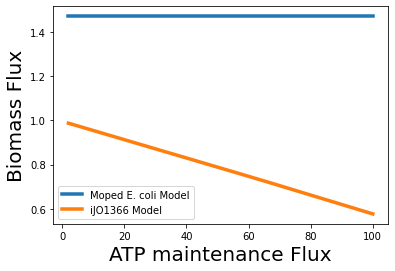

In [12]:
ijo = cobra.io.read_sbml_model("../data/models/iJO1366.xml")

atp_maintenance = np.linspace(2.0, 100, 10)
biomass_by_atp_maintenance_reconstruction = atp_maintenance_scan(
    cobra_model, "ATPase", "BIOMASS", atp_maintenance
)
biomass_by_atp_maintenance_ijo = atp_maintenance_scan(
    ijo, "ATPM", "BIOMASS_Ec_iJO1366_core_53p95M", atp_maintenance
)

fig, ax = plt.subplots()
biomass_by_atp_maintenance_reconstruction.plot(label="Moped E. coli Model", linewidth=3.5, ax=ax)
biomass_by_atp_maintenance_ijo.plot(label="iJO1366 Model", linewidth=3.5, ax=ax)
ax.legend(loc="best")
ax.set_xlabel("ATP maintenance Flux", fontsize=20)
ax.set_ylabel("Biomass Flux", fontsize=20)
plt.show()


As an example manual curation, we identified reversible reactions producing ATP with an iterative process of doing parsimonious FBA and then manually checking backwards running reactions.  
Reversible reactions that have been found to participate in the ATP producing loop were made irreversible, eliminating the ATP producing loop.  

```
pfba = cobra.flux_analysis.pfba(cobra_model)
ecoli.get_producing_reactions(pfba, "ATP_c")
```

In [13]:
cobra_model.reactions.get_by_id("SULFATE-ADENYLYLTRANS-RXN_c").bounds = (0, 1000)
cobra_model.reactions.get_by_id("ADENYL-KIN-RXN_c").bounds = (0, 1000)
cobra_model.reactions.get_by_id("SUCCCOASYN-RXN_c").bounds = (0, 1000)
cobra_model.reactions.get_by_id("GLYCEROL-KIN-RXN_c").bounds = (0, 1000)
cobra_model.reactions.get_by_id("PROPKIN-RXN_c").bounds = (0, 1000)
cobra_model.reactions.get_by_id("ACETATEKIN-RXN_c").bounds = (0, 1000)
cobra_model.reactions.get_by_id("PROPIONYL-COA-CARBOXY-RXN_c").bounds = (0, 1000)

After the manual curation step, now the draft reconstruction and the iJO1366 model behave very similarly, however they are offset.

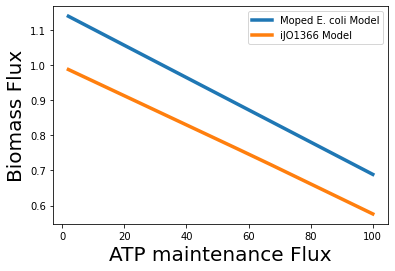

In [16]:
biomass_by_atp_maintenance_reconstruction = atp_maintenance_scan(
    cobra_model, "ATPase", "BIOMASS", atp_maintenance
)

fig, ax = plt.subplots()
biomass_by_atp_maintenance_reconstruction.plot(label="Moped E. coli Model", linewidth=3.5, ax=ax)
biomass_by_atp_maintenance_ijo.plot(label="iJO1366 Model", linewidth=3.5, ax=ax)
ax.legend(loc="best")
ax.set_xlabel("ATP maintenance Flux", fontsize=20)
ax.set_ylabel("Biomass Flux", fontsize=20)
plt.show()


If we correct for the offset, we can see that the models indeed react very similarly to the change in ATP maintenance flux

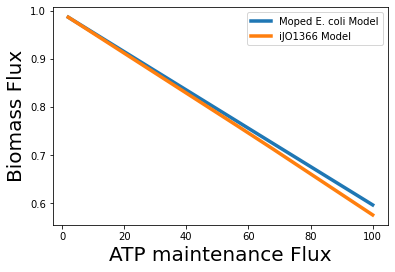

In [26]:
scaled = biomass_by_atp_maintenance_reconstruction * biomass_by_atp_maintenance_ijo.max() / biomass_by_atp_maintenance_reconstruction.max()

fig, ax = plt.subplots()
scaled.plot(label="Moped E. coli Model", linewidth=3.5, ax=ax)
biomass_by_atp_maintenance_ijo.plot(label="iJO1366 Model", linewidth=3.5, ax=ax)
ax.legend(loc="best")
ax.set_xlabel("ATP maintenance Flux", fontsize=20)
ax.set_ylabel("Biomass Flux", fontsize=20)
plt.show()

No we export the model into a fully annotated SBML file to share it with the community.




In [15]:
moped.to_sbml(ecoli, "../temp/ecoli.xml")